GLMMでは$r_i$は1つだったが、K個の場合はK回の多重積分が必要になる。
上記に効くのがマルコフ連鎖モンテカルロ法(MCMC)。

あるデータに対してMCMCアルゴリズムを適用すると、推定結果は確率分布からのランダムサンプルとして得られる。
これをMCMCサンプリング、得られた結果をMCMCサンプルと呼ぶことにする。
MCMCアルゴリズムは他へん量の確率分布からの巧妙な乱数発生方法。
統計モデルを観測データに当てはめるとMCMCサンプルが得られる。

MCMCサンプリングで得られた結果と統計モデルを対応づける方法としてベイズ統計モデルがある。

## 8.1 例題: 種子の生存確率(個体差なし)

種子の生死の問題。各植物個体8この種子の生死を調査。

$\{y_{1}, y_{2}, ..., y_{20}\} = \{4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4\}$

ヒストグラムにすると下記

size : 20
average : 3.65
variance : 2.4275


(array([1., 2., 1., 3., 6., 6., 1.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

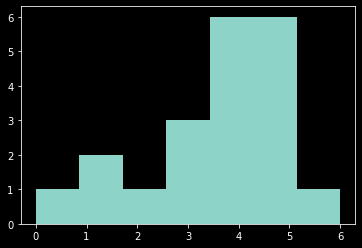

In [7]:
# ダークモードの場合、設定しないとメモリが見えなくなる
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
#y_list = np.array([4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4])
y_list = [4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4]
size = len(y_list)
print("size :", size)
ave = sum(y_list)/len(y_list)
print("average :", ave)
var = np.var(y_list)
print("variance :", var)
plt.hist(y_list, bins=len(set(y_list)))

ヒストグラムを見ると過分散ではないように見える。
そのため生存種子数$y_i$が二項分布に従うと仮定する。均質な20個体に共通する種子生存確率をqとするとある個体iの種子数が$y_i$である確率は下記。

$p(y_i| q) = \begin{pmatrix} 8 \\ y_i \end{pmatrix} q_i^{y_i}(1-q_i)^{8-y_i}$

尤度$L(q)$は20個体分のデータが得られる確率の積なので下記。

$L(q) = p(Y|q) = \Pi_ip(y_i|q)$

対数尤度は下記

$log L(q) = \sum_i\{y_i log q + (8-y_i) log(1-q)\} + (定数)$

尤度はq=0.46あたりで対数尤度が最大になるらしい。求め方わからん。

この対数尤度logL(q)を最大化するようなqが最大推定値$\hat{q}$で、対数尤度の傾きがゼロになる。
つまりdlogL(q)/dq = 0となる$\hat{q}$を求めると、Yのもとでの最尤推定値は以下になる。

$\hat{q} = \frac{合計生存種子数}{合計調査種子数} = \frac{73}{8 * 20} = 0.456$

このデータから生存確率は0.46くらい。

## 8.2 フラフラ試行錯誤による最尤推定

最尤推定陵$\hat{q}$が解析的に求められない倍位はどうすれば良いか。
計算機による繰り返し試行錯誤でqを少しずつ変化させることで対数尤度が高くなる$\hat{q}$を探し出す。
下記にMCMCで効率悪い精度も良くない試行錯誤による最尤推定方法を紹介する。

1. 生存確率qを離散化(連続値のqを飛び飛びの値の集まりに変換すること)

q=0.01から0.99までの値に変更

2. 何かqの初期値を選び、その対数尤度を評価する。

試行錯誤による最尤推定方ではいい加減に決めたqを振り出しにして、qを増減しながら対数尤度が高くなるqを逐次的に探していく。

最終的にq=0.46のあたりに着く

8.3 MCMCのアルゴリズムの一つ: メトロポリス法

メトロポリス法は上記のフラフラ試行錯誤による最尤推定の手順を少し修正したもの。

1. パラメータqの初期値を選ぶ

2. qを増やすor減らすかをランダムに決める。それを$q^{new}$とする

3. $q^{new}$において尤度が大きくなる(当てはまりが良くなる)ならqの値を$q^{new}$に変更

4. $q^{new}$で尤度が小さくなる場合であっても確率rでqの値を$q^{new}$に変更する

rは下記。

$r=\frac{L(q)^{new}}{L(q)}$

(ε-greedyみたい)

例:

$q=0.30, q^{new} = 0.29$の場合、対数尤度はそれぞれ$logL(q) = -46.38, logL(q^{new}) = -47.62$なので、移動する確率は

$r=exp(-47.62 + 46.38) = 0.29$になる。(平然とlogの計算をしていくー笑)

MCMCアルゴリズムでは一つのステップの中で前の状態qに基づいて新しい状態$q^{new}$を作り出しているのでマルコフ連鎖になっている。
(現在の状態にしか依存していないことでOK?)

https://ja.wikipedia.org/wiki/%E3%83%9E%E3%83%AB%E3%82%B3%E3%83%95%E9%80%A3%E9%8E%96

一般に乱数を利用した計算アルゴリズムはモンテカルロ法と呼ばれている。
2. と4. で乱数を使っているので、メトロポリス法はマルコフ連鎖なモンテカルロ法の一つであることがわかる。

In [31]:
import math
from scipy.special import comb
import pandas as pd

# 対数尤度
def loglikelihood(data, q):
    ll = 0
    for i, r in data.iterrows():
        ll = ll + math.log(comb(r['N'], r['y'])) + r['y']*math.log(q) + (r['N'] - r['y'])*math.log(1 - q)

    return ll

# MCMC(メトロポリス法)
def mcmc_metropolis(data, q_start, number_of_samples):
    q_current = q_start
    ll_current = loglikelihood(data, q_current)
    q = [q_current]
    ll = [ll_current]
    for r1, r2 in zip(np.random.random(number_of_samples), np.random.random(number_of_samples)):
        q_new = q_current + 0.01 if r1 > 0.5 else q_current - 0.01
        if q_new <= 0.01:
            q_new = 0.02
        elif q_new >= 0.99:
            q_new = 0.98
        ll_new = loglikelihood(data, q_new)
        # 対数尤度が悪くなる場合でも、尤度比の確率でqを更新
        if ll_current < ll_new or (math.exp(ll_new - ll_current)  > r2):
            q_current = q_new
            ll_current = ll_new
        q.append(q_current)
        ll.append(ll_current)
    return q, ll

n_list = [8] * len(y_list)
zipped = zip(n_list, y_list)
df = pd.DataFrame([list(a) for a in zipped], columns=["N", "y"])

# サンプル数100のMCMCでqと対数尤度の遷移を計算
q_100, ll_100 = mcmc_metropolis(df, 0.3, 100)

## 8.3.1 メトロポリス法でサンプリングしてみる
